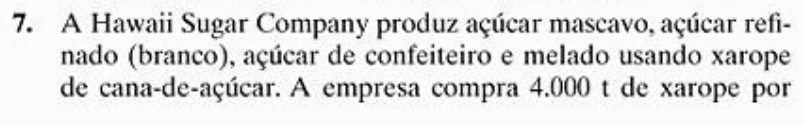

In [1]:
%pip install cplex
%pip install docplex

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
from docplex.mp.model import Model

# Criação do modelo com um nome descritivo
model = Model('Producao_Acucar_Hawaii')

In [3]:
# --- Parâmetros extraídos do enunciado ---

# Limite de matéria-prima (toneladas/semana)
limite_xarope = 4000

# Lucro por tonelada para cada produto final vendido
lucro_por_tonelada = {
    'mascavo': 150,
    'refinado': 200,
    'confeiteiro': 230,
    'melado': 35
}

# Fatores de conversão (rendimento) do processo
rendimento = {
    'mascavo_de_xarope': 0.3,
    'melado_de_xarope': 0.1,
    'refinado_de_mascavo': 0.8,
    'confeiteiro_de_refinado': 0.95
}

# Contratos de entrega mínima (toneladas/semana)
demanda_minima_ton = {
    'mascavo': 25,
    'refinado': 25,
    'confeiteiro': 25
}

In [4]:
# 1. Variáveis de Decisão
# Representam o FLUXO de materiais no processo (toneladas)

# Insumo principal
xarope_usado = model.continuous_var(name='Xarope_Usado', lb=0)

# Fluxos do Açúcar Mascavo
mascavo_vendido = model.continuous_var(name='Mascavo_Vendido', lb=0)
mascavo_processado = model.continuous_var(name='Mascavo_Processado', lb=0)

# Fluxos do Açúcar Refinado
refinado_vendido = model.continuous_var(name='Refinado_Vendido', lb=0)
refinado_processado = model.continuous_var(name='Refinado_Processado', lb=0)

# Expressões auxiliares para clareza (produção em cada estágio)
# Não são variáveis, mas sim cálculos baseados nas variáveis de decisão.
mascavo_produzido = rendimento['mascavo_de_xarope'] * xarope_usado
melado_produzido = rendimento['melado_de_xarope'] * xarope_usado
refinado_produzido = rendimento['refinado_de_mascavo'] * mascavo_processado
confeiteiro_produzido = rendimento['confeiteiro_de_refinado'] * refinado_processado


# 2. Função Objetivo
# Maximizar o lucro total (soma do lucro de cada produto vendido)
lucro_total = (lucro_por_tonelada['mascavo'] * mascavo_vendido +
               lucro_por_tonelada['refinado'] * refinado_vendido +
               lucro_por_tonelada['confeiteiro'] * confeiteiro_produzido +
               lucro_por_tonelada['melado'] * melado_produzido)
model.maximize(lucro_total)


# 3. Restrições

# Restrição 1: Limite de Matéria-Prima
restr_limite_xarope = xarope_usado <= limite_xarope
model.add_constraint(restr_limite_xarope, ctname='limite_xarope')

# Restrição 2: Balanço do Açúcar Mascavo
# O que foi produzido (de xarope) deve ser igual ao que foi vendido mais o que foi processado.
restr_balanco_mascavo = mascavo_produzido == mascavo_vendido + mascavo_processado
model.add_constraint(restr_balanco_mascavo, ctname='balanco_mascavo')

# Restrição 3: Balanço do Açúcar Refinado
# O que foi produzido (de mascavo) deve ser igual ao que foi vendido mais o que foi processado.
restr_balanco_refinado = refinado_produzido == refinado_vendido + refinado_processado
model.add_constraint(restr_balanco_refinado, ctname='balanco_refinado')

# Restrição 4: Contratos de Entrega Mínima
restr_min_mascavo = mascavo_vendido >= demanda_minima_ton['mascavo']
model.add_constraint(restr_min_mascavo, ctname='min_mascavo')

restr_min_refinado = refinado_vendido >= demanda_minima_ton['refinado']
model.add_constraint(restr_min_refinado, ctname='min_refinado')

restr_min_confeiteiro = confeiteiro_produzido >= demanda_minima_ton['confeiteiro']
model.add_constraint(restr_min_confeiteiro, ctname='min_confeiteiro')

docplex.mp.LinearConstraint[min_confeiteiro](0.950Refinado_Processado,GE,25)

In [5]:
# Aciona o solver para encontrar a solução
print("--- Resolvendo o modelo ---")
solucao = model.solve(log_output=True)

print('\n------ SOLUÇÃO ÓTIMA ------\n')
if solucao:
    lucro_maximo = model.objective_value
    print(f"Lucro Semanal Máximo: ${lucro_maximo:,.2f}\n")

    print("--- Plano de Produção e Venda (toneladas/semana) ---")
    print(f"  - Xarope a ser comprado: {xarope_usado.solution_value:,.2f}")
    print(f"  - Açúcar Mascavo:")
    print(f"    - Produzido: {mascavo_produzido.solution_value:,.2f}")
    print(f"    - Vendido:   {mascavo_vendido.solution_value:,.2f}")
    print(f"    - Processado para Refinado: {mascavo_processado.solution_value:,.2f}")
    print(f"  - Açúcar Refinado:")
    print(f"    - Produzido: {refinado_produzido.solution_value:,.2f}")
    print(f"    - Vendido:   {refinado_vendido.solution_value:,.2f}")
    print(f"    - Processado para Confeiteiro: {refinado_processado.solution_value:,.2f}")
    print(f"  - Açúcar de Confeiteiro vendido: {confeiteiro_produzido.solution_value:,.2f}")
    print(f"  - Melado vendido: {melado_produzido.solution_value:,.2f}")
else:
    print("Não foi possível encontrar uma solução.")

--- Resolvendo o modelo ---
Version identifier: 22.1.2.0 | 2024-12-10 | f4cec290b
CPXPARAM_Read_DataCheck                          1
Tried aggregator 1 time.
LP Presolve eliminated 4 rows and 3 columns.
Aggregator did 2 substitutions.
All rows and columns eliminated.
Presolve time = 0.00 sec. (0.00 ticks)

------ SOLUÇÃO ÓTIMA ------

Lucro Semanal Máximo: $222,677.50

--- Plano de Produção e Venda (toneladas/semana) ---
  - Xarope a ser comprado: 4,000.00
  - Açúcar Mascavo:
    - Produzido: 1,200.00
    - Vendido:   25.00
    - Processado para Refinado: 1,175.00
  - Açúcar Refinado:
    - Produzido: 940.00
    - Vendido:   25.00
    - Processado para Confeiteiro: 915.00
  - Açúcar de Confeiteiro vendido: 869.25
  - Melado vendido: 400.00
